### Importação das Bibliotecas

In [21]:
import copy
import sys
from subprocess import getoutput as gop

import matplotlib.pyplot as plt
import mne
import numpy as np
from mne.time_frequency import psd_welch as psdw

### Função: loadData(arquivo)

Carrega a data de cada arquivo encontrado na pasta e retorna um array onde a primeira posição contém a data importada e na segunda posição se encontra o tempo de leituda da data (incrementa-se a cada 256 valores).

In [22]:
def loadData(arquivo):
    arqOpen = open(f'data_10hz/{arquivo}')
    fileLimitTime = 0
    
    for _ in range(6):
        next(arqOpen)
    
    eeg = list()
    person = list()
    for row in arqOpen:
        columns = row.split(',')

        if columns:
            columns = columns[:7]
                    
            if(columns[0] == '0'):
                if(len(eeg) == 256):
                    fileLimitTime +=1
                    for k in eeg:
                        person.append(list(map(lambda i : float(i), k[1:])))
                eeg = list()
            
            eeg.append(columns)

    return [np.array(person).T, fileLimitTime]

###  Função: prepareRaw(data)

Prepara o rawArray que contém os dados da base importados, que posteriormente serão transformados do domínio do tempo para o dominio da frequência.
- Selecionamos os eletrodos de 1 a 6 da base dados excluindo.
- Aplicamos o filtro da faixa de 5HZ até 50HZ 5 vezes para excluir bordas que atrapalhariam na identificação dos ritmos alpha.

In [12]:
def prepareRaw(data):
    info = mne.create_info(ch_names=['eeg'] * 6, sfreq=256, ch_types=['eeg'] * 6)
    raw = mne.io.RawArray(data, info)

    for _ in range(5):
        raw.filter(l_freq=5, h_freq=50)

    return raw

### Função: scaleValue(max, min)

Escala um valor de 0 a 100.

In [13]:
def scaleValue(max, min):
    return ((min*100)/max)

### Fuanção: finAlphaTime(raw, tmin, window)

Encontra os tempos em que ocorre o chamado ritmo alpha.

Separa as frequências:
- alpha (8HZ - 12 HZ)
- theta (5HZ - 7HZ)
- beta (12HZ - 30HZ)
- gama (25HZ - 100HZ)

Posteriormente verifica se alhpa é a maior de todas, caso sim, acha a segunda maior e tira a diferença de ambas mostrando o tempo e o valor escalado da diferença em porcentagem. 

In [23]:
def findAlphaTime(raw, tmin, window):
    faixas = list()
    
    alpha = psdw(raw, tmin=tmin, tmax=tmin+window, fmin=8,  fmax=12,  verbose=False)[0]   
    theta = psdw(raw, tmin=tmin, tmax=tmin+window, fmin=5,  fmax=7,   verbose=False)[0]
    beta  = psdw(raw, tmin=tmin, tmax=tmin+window, fmin=12, fmax=30,  verbose=False)[0]
    gamma = psdw(raw, tmin=tmin, tmax=tmin+window, fmin=25, fmax=100, verbose=False)[0]
    
    faixas.append(np.average(alpha))
    faixas.append(np.average(theta))
    faixas.append(np.average(beta))
    faixas.append(np.average(gamma))
    
    indexMaiorFaixa = np.argmax(np.array(faixas))
    
    if (indexMaiorFaixa == 0):
        indexSegMaiorFaixa = np.argmax(np.array(faixas[1:]))+1
        print(f'tempo {tmin} - {tmin+window}: {scaleValue(faixas[indexMaiorFaixa], faixas[indexSegMaiorFaixa])} %')

### Função: plotWindowTime(raw, tmin, window, fmax=30)

Plota alguns dos tempos encontrados anteriormente após filtragem e seleção manual.

In [19]:
def plotWindowTime(raw, tmin, window, fmax=30):
    psds, freqs = psdw(raw, tmin=tmin, tmax=tmin+window, fmax=fmax)
    psd_Average = np.average(psds, axis=0) ** 2
    plt.xlabel(f'{tmin} - {tmin+window}', horizontalalignment='center', verticalalignment='top')
    plt.plot(freqs, psd_Average)
    plt.show()

### Função Principal

Responsável por ler os arquivos contidos nas pastas, importar as datas, preparar o raw, encontrar os tempos de ritmo alpha e plotar alguns destes tempos selecionados. A janela é de 3 segundos no exemplo abaixo.

(6, 204288)
Creating RawArray with float64 data, n_channels=6, n_times=204288
    Range : 0 ... 204287 =      0.000 ...   797.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

<ipython-input-12-98f0b9d3fac5>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'eeg'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names=['eeg'] * 6, sfreq=256, ch_types=['eeg'] * 6)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge:

tempo 557 - 560: 15.820251967622568 %
tempo 558 - 561: 23.52560240683513 %
tempo 559 - 562: 51.12646859506578 %
tempo 562 - 565: 56.92972927581794 %
tempo 563 - 566: 69.01391442561629 %
tempo 565 - 568: 91.28733451070117 %
tempo 566 - 569: 78.63810599570274 %
tempo 567 - 570: 69.67999214402353 %
tempo 568 - 571: 68.03777558111892 %
tempo 569 - 572: 61.32873600403653 %
tempo 570 - 573: 45.184894123121836 %
tempo 571 - 574: 46.18297961647853 %
tempo 572 - 575: 39.99880120657397 %
tempo 573 - 576: 17.343629756454668 %
tempo 574 - 577: 17.66743925368467 %
tempo 575 - 578: 21.611494823908373 %
tempo 576 - 579: 89.782491640244 %
tempo 581 - 584: 71.77093173288667 %
tempo 582 - 585: 84.77715812644446 %
tempo 592 - 595: 99.52079053685065 %
tempo 597 - 600: 99.79576092342545 %
tempo 615 - 618: 31.679107755507506 %
tempo 616 - 619: 23.58920964900392 %
tempo 617 - 620: 23.15943908026398 %
tempo 618 - 621: 23.961209614682346 %
tempo 619 - 622: 30.53753033928913 %
tempo 620 - 623: 28.02267163734005

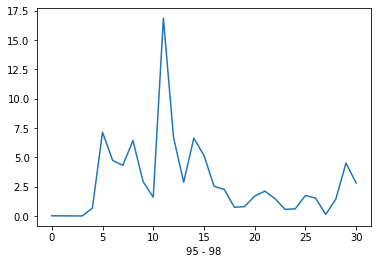

Effective window size : 1.000 (s)


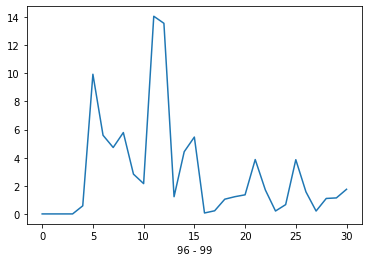

Effective window size : 1.000 (s)


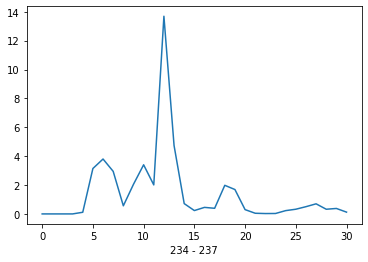

Effective window size : 1.000 (s)


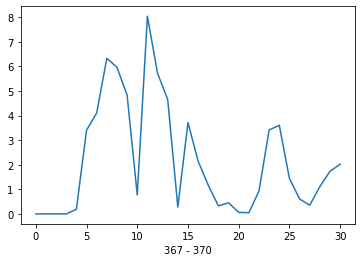

Effective window size : 1.000 (s)


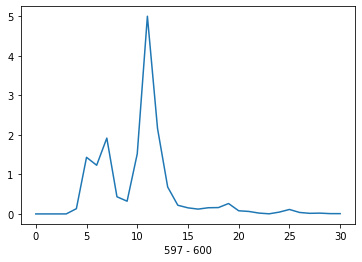

Effective window size : 1.000 (s)


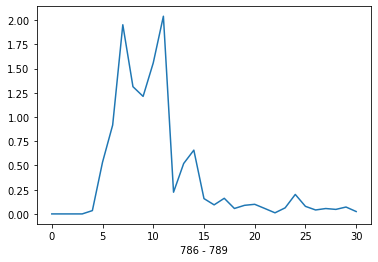

(6, 130304)
Creating RawArray with float64 data, n_channels=6, n_times=130304
    Range : 0 ... 130303 =      0.000 ...   508.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB s

<ipython-input-12-98f0b9d3fac5>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'eeg'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names=['eeg'] * 6, sfreq=256, ch_types=['eeg'] * 6)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)

tempo 0 - 3: 89.84405179722891 %
tempo 22 - 25: 87.4086101912333 %
tempo 29 - 32: 79.80506483448283 %
tempo 31 - 34: 84.98424888418855 %
tempo 39 - 42: 96.49441358722714 %
tempo 44 - 47: 69.3772759474632 %
tempo 45 - 48: 88.569844820625 %
tempo 46 - 49: 93.75805892671426 %
tempo 92 - 95: 50.06287224984472 %
tempo 93 - 96: 50.86282260900373 %
tempo 94 - 97: 58.96481095213764 %
tempo 98 - 101: 69.87048459981278 %
tempo 99 - 102: 66.904

tempo 482 - 485: 75.52932649083776 %
tempo 483 - 486: 45.552642514899965 %
tempo 484 - 487: 55.50121858394625 %
tempo 486 - 489: 85.52623311834536 %
tempo 487 - 490: 62.01163735950441 %
tempo 488 - 491: 54.80951164356062 %
tempo 489 - 492: 54.532108895273026 %
tempo 490 - 493: 80.28996646282029 %
tempo 491 - 494: 59.39286257876392 %
tempo 492 - 495: 21.01952621935654 %
tempo 493 - 496: 26.049634159974286 %
tempo 494 - 497: 30.934456080781853 %
tempo 495 - 498: 89.01459814747896 %
tempo 496 - 499: 48.63348480765945 %
tempo 497 - 500: 47.4723040548085 %
tempo 498 - 501: 60.15742237046883 %
tempo 499 - 502: 73.68772628627693 %
tempo 500 - 503: 73.7010863424446 %
tempo 501 - 504: 90.34925569021557 %
tempo 505 - 508: 94.08862393218979 %
Effective window size : 1.000 (s)


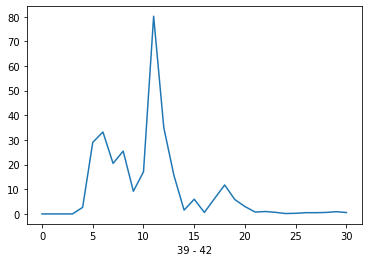

Effective window size : 1.000 (s)


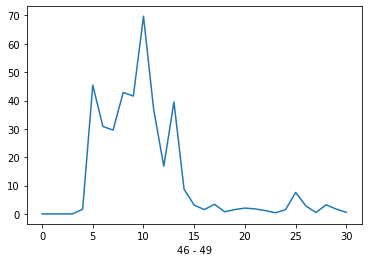

Effective window size : 1.000 (s)


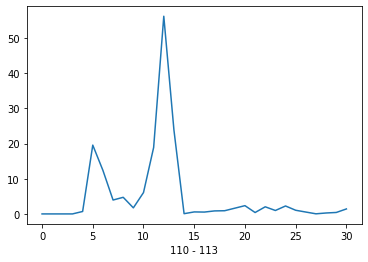

Effective window size : 1.000 (s)


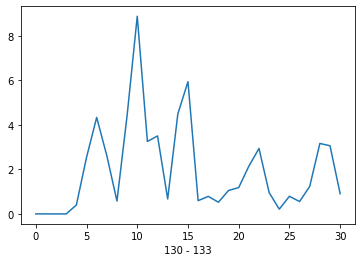

Effective window size : 1.000 (s)


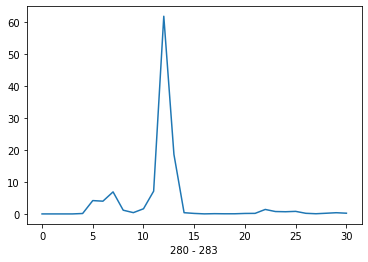

Effective window size : 1.000 (s)


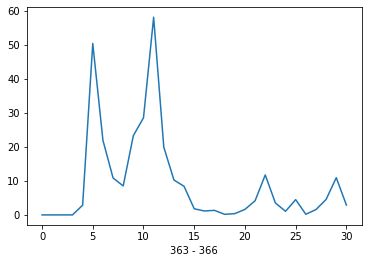

(6, 59904)
Creating RawArray with float64 data, n_channels=6, n_times=59904
    Range : 0 ... 59903 =      0.000 ...   233.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stop

<ipython-input-12-98f0b9d3fac5>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'eeg'}. Applying running numbers for duplicates.
  info = mne.create_info(ch_names=['eeg'] * 6, sfreq=256, ch_types=['eeg'] * 6)


tempo 103 - 106: 86.1282674998417 %
tempo 104 - 107: 68.96637478107175 %
tempo 105 - 108: 63.83923145641066 %
tempo 109 - 112: 63.57639268659411 %
tempo 111 - 114: 79.75297923237257 %
tempo 112 - 115: 77.25355942595667 %
tempo 114 - 117: 88.6151936158768 %
tempo 136 - 139: 99.41373567608971 %
tempo 151 - 154: 79.95468112105672 %
tempo 152 - 155: 76.43171699495902 %
tempo 153 - 156: 54.3369224280963 %
tempo 154 - 157: 93.36137076936213 %
tempo 155 - 158: 79.31158659611005 %
tempo 157 - 160: 85.31326202421742 %
tempo 158 - 161: 85.26756610744319 %
tempo 159 - 162: 61.54288748267093 %
tempo 160 - 163: 77.93205842012836 %
tempo 164 - 167: 66.6682573303777 %
tempo 165 - 168: 69.33907380647828 %
tempo 170 - 173: 88.52424993752258 %
tempo 171 - 174: 92.98145469305322 %
tempo 172 - 175: 85.57078588707385 %
tempo 173 - 176: 73.90309263885821 %
tempo 177 - 180: 77.77964218065227 %
tempo 178 - 181: 47.39454744805641 %
tempo 179 - 182: 43.9294007174065 %
tempo 180 - 183: 57.69013374352607 %
tempo 

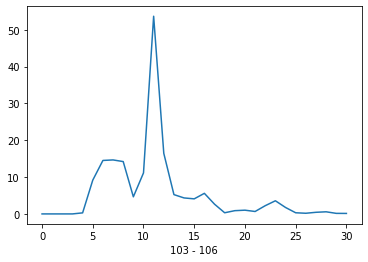

Effective window size : 1.000 (s)


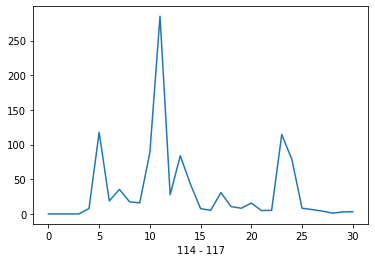

Effective window size : 1.000 (s)


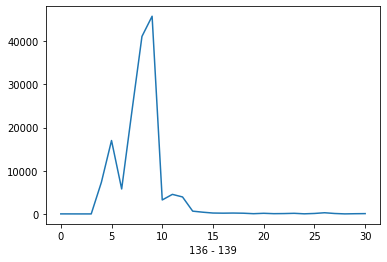

Effective window size : 1.000 (s)


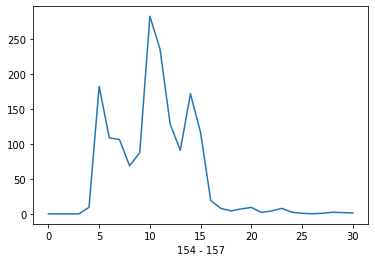

Effective window size : 1.000 (s)


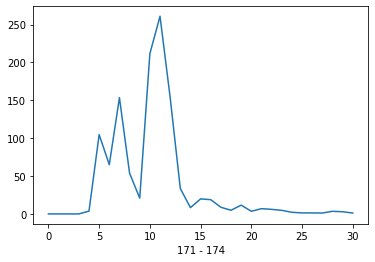

Effective window size : 1.000 (s)


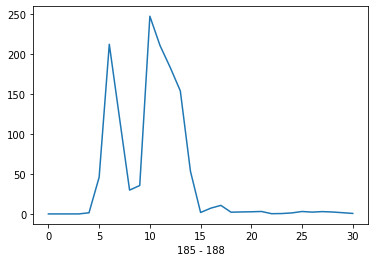

In [24]:
# arquivos
arquivos = gop('ls data_10hz').split('\n')

# Tempos selecionados a mão
times = [[95, 96, 234, 367, 597, 786],
        [39, 46, 110, 130, 280, 363],
        [103, 114, 136, 154, 171, 185]]
window = 3

# Para cada arquivo
for arqPos, arq in enumerate(arquivos):
    data, fileLimitTime = loadData(arq)
    print(data.shape)
    raw = prepareRaw(data)

    # acha os tempos do ritmo alpha
    for i in range(fileLimitTime - window):
        findAlphaTime(raw, i, window)

    # plota os tempos selecionados
    for i in times[arqPos]:
        plotWindowTime(raw, i, window)